# Predicting house price using linear regression

## Required modules

In [16]:
import tensorflow as tf
import pandas as pd 
import seaborn as sns
#import tensorflow.feature_column as fc
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import boston_housing
from datetime import datetime

## download the Boston housing price dataset
(http://lib.stat.cmu.edu/datasets/boston)

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

Variables in order:

**CRIM:** per capita crime rate by town  
**ZN:** proportion of residential land zoned for lots over 25,000 sq.ft.  
**INDUS:** proportion of non-retail business acres per town  
**CHAS:** Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)  
**NOX:** nitric oxides concentration (parts per 10 million)  
**RM:** average number of rooms per dwelling  
**AGE:** proportion of owner-occupied units built prior to 1940  
**DIS:** weighted distances to five Boston employment centres  
**RAD:** index of accessibility to radial highways  
**TAX:** full-value property-tax rate per \$10,000  
**PTRATIO:** pupil-teacher ratio by town  
**B:** 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town  
**LSTAT:** % lower status of the population  
**MEDV:** Median value of owner-occupied homes in \$1000's

In [17]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

## create pandas dataframe

In [18]:
features = ['CRIM', 'ZN', 
            'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
            'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
x_train_df = pd.DataFrame(x_train, columns = features)
x_test_df = pd.DataFrame(x_test, columns = features)
y_train_df = pd.DataFrame(y_train, columns = ['MEDV'])
y_test_df = pd.DataFrame(y_test, columns = ['MEDV'])

x_train_df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


## inspect the data

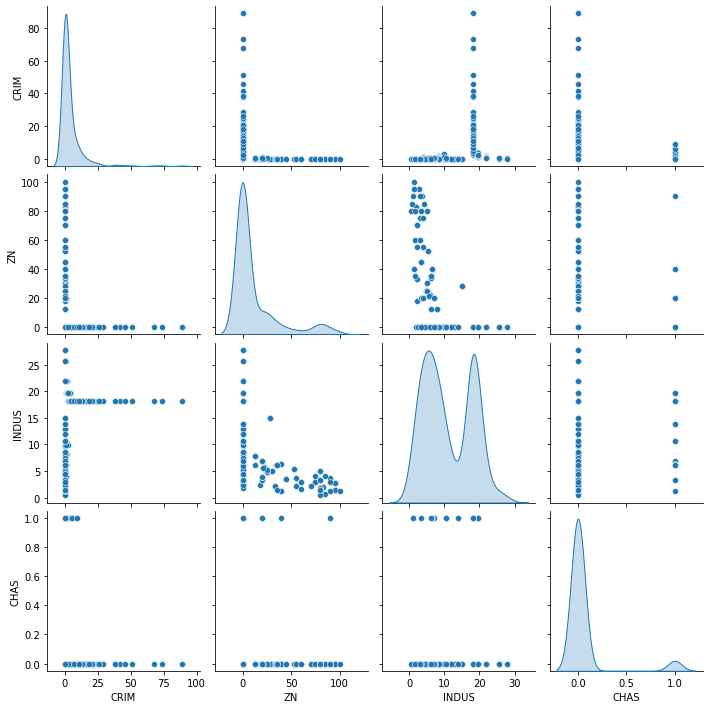

In [19]:
sns.pairplot(x_train_df[['CRIM', 'ZN', 'INDUS', 'CHAS']], diag_kind='kde')

In [20]:
train_stats = x_train_df.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CRIM,404.0,3.745111,9.240734,0.00632,0.081437,0.26888,3.674808,88.9762
ZN,404.0,11.480198,23.767711,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,404.0,11.104431,6.811308,0.46000,5.130000,9.69000,18.100000,27.7400
CHAS,404.0,0.061881,0.241238,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,404.0,0.557356,0.117293,0.38500,0.453000,0.53800,0.631000,0.8710
RM,404.0,6.267082,0.709788,3.56100,5.874750,6.19850,6.609000,8.7250
AGE,404.0,69.010644,27.940665,2.90000,45.475000,78.50000,94.100000,100.0000
DIS,404.0,3.740271,2.030215,1.12960,2.077100,3.14230,5.118000,10.7103
RAD,404.0,9.440594,8.698360,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,404.0,405.898515,166.374543,188.00000,279.000000,330.00000,666.000000,711.0000


## normalize the train dataset

In [21]:
mu = x_train_df.mean()
sigma = x_train_df.std()
x_train_norm = (x_train_df - mu) / sigma
x_train_norm.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.271909,-0.483017,-0.435222,-0.256515,-0.165022,-0.176224,0.812055,0.116554,-0.625474,-0.594433,1.147078,0.447522,0.824198
1,-0.402927,2.988079,-1.332260,-0.256515,-1.213677,1.892000,-1.907995,1.246040,-0.855402,-0.348001,-1.716061,0.431371,-1.327556
2,0.124785,-0.483017,1.027052,-0.256515,0.627864,-1.827422,1.109113,-1.185969,1.673810,1.563349,0.783505,0.220344,-1.306880
3,-0.400996,-0.483017,-0.868325,-0.256515,-0.361112,-0.324156,-1.235140,1.105809,-0.510509,-1.093307,0.783505,0.447522,-0.652118
4,-0.005627,-0.483017,1.027052,-0.256515,1.326967,0.153452,0.693948,-0.577856,1.673810,1.563349,0.783505,0.389399,0.263171


## normalize the test dataset
I used same mu and sigma computed in the train dataset

In [22]:
x_test_norm = (x_test_df - mu) / sigma
x_test_norm.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.551769,-0.483017,1.027052,-0.256515,1.037095,0.235167,1.109113,-0.938606,1.673810,1.563349,0.783505,-3.480280,2.248133
1,-0.391941,-0.483017,-0.160679,-0.256515,-0.088291,-0.498856,0.855003,-0.683115,-0.395545,0.156884,-0.307215,0.426802,0.478208
2,-0.399334,-0.483017,-0.868325,-0.256515,-0.361112,-0.397417,-0.845028,0.527988,-0.510509,-1.093307,0.783505,0.447522,-0.413646
3,-0.267473,-0.483017,1.244338,3.888763,0.406197,-0.024066,0.844266,-0.956485,-0.510509,-0.017422,-1.716061,-0.168558,-0.998108
4,-0.397544,-0.483017,-0.971096,-0.256515,-0.923805,-0.205810,-0.437021,0.003610,-0.740438,-0.955065,0.010912,0.428927,-0.592844


## Create the model

In [23]:
def create_model():
    N_HIDDEN = 128
    N_FEATURES = 13

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        N_HIDDEN,
        name='layer_1', 
        activation='relu', 
        input_shape=(N_FEATURES,)))

    model.add(tf.keras.layers.Dense(
        N_HIDDEN,
        name='layer_2',
        activation='relu'))

    model.add(tf.keras.layers.Dense(
        1,
        name='output_layer',        
        activation='linear'
    ))

    optimizer = tf.keras.optimizers.RMSprop(
        learning_rate=0.001,
        rho=0.9,
        momentum=0.0,
        epsilon=1e-7
    )

    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model


In [24]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 128)               1792      
_________________________________________________________________
layer_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 18,433
Trainable params: 18,433
Non-trainable params: 0
_________________________________________________________________


## train the model

In [25]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

BATCH_SIZE=128
EPOCHS=100

history = model.fit(
            x_train_norm,
            y_train_df,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1,
            validation_split=0.2,
            callbacks=[tensorboard_callback]
)



Epoch 1/100
3/3 [==============================] - 1s 114ms/step - loss: 550.4814 - mae: 21.5963 - mse: 550.4814 - val_loss: 576.5307 - val_mae: 22.2186 - val_mse: 576.5307
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 489.9743 - mae: 20.2310 - mse: 489.9743 - val_loss: 522.6733 - val_mae: 21.0102 - val_mse: 522.6733
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 438.2487 - mae: 18.9742 - mse: 438.2487 - val_loss: 471.2172 - val_mae: 19.7739 - val_mse: 471.2172
Epoch 4/100
3/3 [==============================] - 0s 11ms/step - loss: 388.0602 - mae: 17.6838 - mse: 388.0602 - val_loss: 418.1911 - val_mae: 18.4692 - val_mse: 418.1911
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 337.4223 - mae: 16.3127 - mse: 337.4223 - val_loss: 366.2173 - val_mae: 17.0854 - val_mse: 366.2173
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 289.2230 - mae: 14.9036 - mse: 289.2230 - val_loss: 317.7079 - val_

In [26]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,7.371208,1.884307,7.371208,16.093365,2.670622,16.093365,95
96,7.539245,1.911827,7.539245,16.978477,2.651972,16.978477,96
97,7.336706,1.881419,7.336706,19.076378,2.813531,19.076378,97
98,7.821676,1.989797,7.821676,15.684228,2.662005,15.684228,98
99,7.242993,1.865895,7.242993,15.451870,2.607982,15.451870,99


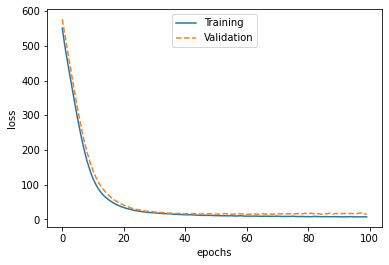

In [27]:
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim([0, 100])
plt.plot(history_df['epoch'], history_df['loss'], label='Training')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation', linestyle='dashed')
plt.legend(loc='upper center', shadow=False)

## make predictions

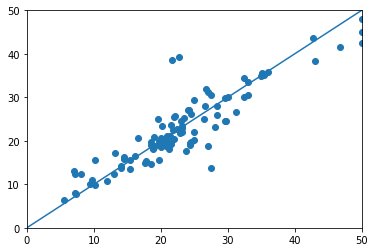

In [28]:
test_predictions = model.predict(x_test_norm)

#a = plt.axis(aspect='equal')
plt.scatter(y_test, test_predictions)
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [29]:
loss, mae, mse = model.evaluate(x_test_norm, y_test, verbose=1)

print("Testing set Mean Absolute Error: {:5.2f}".format(mae))
print("Testing set Loss: {:5.2f}".format(loss))

4/4 [==============================] - 0s 3ms/step - loss: 26.4675 - mae: 2.9767 - mse: 26.4675
Testing set Mean Absolute Error:  2.98
Testing set Loss: 26.47


## examining metrics in TensorBoard

%tensorboard --logdir logs/scalars